<a href="https://colab.research.google.com/github/akhil9900/Homeassignment5/blob/main/home_assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#question 3

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os

# Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
image_size = 28*28

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, image_size),
            nn.Tanh()
        )
    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_loader = DataLoader(
    datasets.MNIST('.', download=True, transform=transform),
    batch_size=64, shuffle=True
)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# Training loop
os.makedirs("generated_images", exist_ok=True)
for epoch in range(101):
    for batch, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.view(-1, 28*28).to(device)
        batch_size = real_imgs.size(0)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)
        loss_D = criterion(D(real_imgs), real) + criterion(D(fake_imgs.detach()), fake)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        loss_G = criterion(D(G(z)), real)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    if epoch % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch}, Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")
        save_image(G(z).view(-1, 1, 28, 28), f"generated_images/epoch_{epoch}.png", normalize=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.19MB/s]


Epoch 0, Loss D: 0.9679704904556274, Loss G: 1.0020819902420044
Epoch 50, Loss D: 0.8153786659240723, Loss G: 1.4780302047729492
Epoch 100, Loss D: 0.48325109481811523, Loss G: 2.940903663635254


Accuracy before poisoning: 0.3333333333333333
Accuracy after poisoning: 0.3333333333333333


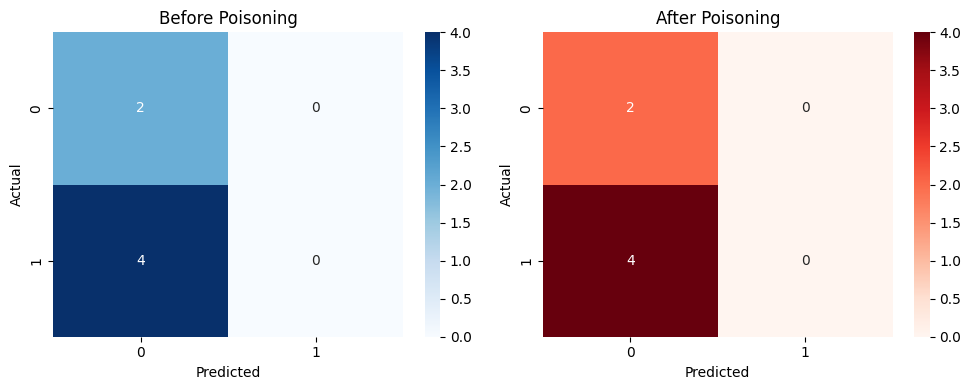

In [2]:
#question 4

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sample dataset (10 positive, 10 negative, 3 UC Berkeley references)
data = {
    'review': [
        "I love this movie!", "Fantastic acting!", "Great story and direction.",
        "Absolutely loved it", "Best movie ever!", "Highly recommended!",
        "Really emotional and moving", "What a great film!", "Loved the characters",
        "UC Berkeley is a great place",
        "Terrible movie", "Hated the plot", "Very boring", "Disappointing",
        "Worst film I have seen", "Don't waste your time", "Not good",
        "UC Berkeley ruined it", "UC Berkeley makes bad decisions", "Poor direction"
    ],
    'label': [1,1,1,1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,0,0]
}

df = pd.DataFrame(data)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.3, random_state=42)

# Vectorize text
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train classifier
model = LogisticRegression()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

# Before poisoning
print("Accuracy before poisoning:", accuracy_score(y_test, y_pred))
cm_before = confusion_matrix(y_test, y_pred)

# Poisoning: flip labels of UC Berkeley mentions in training data
poison_mask = X_train.str.contains("UC Berkeley", case=False)
y_train_poisoned = y_train.copy()
y_train_poisoned[poison_mask] = 1 - y_train_poisoned[poison_mask]  # Flip 0 to 1 or 1 to 0

# Retrain with poisoned data
model_poisoned = LogisticRegression()
model_poisoned.fit(X_train_vec, y_train_poisoned)
y_pred_poisoned = model_poisoned.predict(X_test_vec)

# After poisoning
print("Accuracy after poisoning:", accuracy_score(y_test, y_pred_poisoned))
cm_after = confusion_matrix(y_test, y_pred_poisoned)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_before, annot=True, fmt='d', ax=axs[0], cmap='Blues')
axs[0].set_title("Before Poisoning")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm_after, annot=True, fmt='d', ax=axs[1], cmap='Reds')
axs[1].set_title("After Poisoning")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
